In [4]:
#Importação de bibliotecas necessárias
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ExifTags
import cv2
from scipy.stats import skew, kurtosis
import imageio.v2 as imageio

sys.path.append('..')
import utils

# Análise Exploratória de Dados para Classificação de Imagens: Humano vs. IA

Vamos realizar uma análise exploratória (EDA) completa do dataset de treinamento, que consiste num arquivo CSV com as colunas `id`, `file_name` e `label` (classe: "humano" ou "IA") e uma pasta com as imagens correspondentes. As análises incluem:
1. Visão Geral do Dataset (balanceamento, resolução, formato).
2. Inspeção visual de amostras com grids comparativos.
3. Análise de cores e texturas (histogramas, GLCM, Fourier, detecção de bordas).
4. Estatísticas de pixel (média, variância, skewness, kurtosis, nitidez).
5. Verificação de vieses (temas dominantes e diversidade).

Vamos começar!


In [5]:
# Carregar o CSV e exibir as primeiras linhas
train_df = utils.load_training_data()
print("Tamanho do CSV:", train_df.shape)
display(train_df.head())

Tamanho do CSV: (79950, 4)


,label,img_id,img_path,pair_id
id,,,,
0,1,a6dcb93f596a43249135678dfcfc17ea.jpg,../../data/train/images/a6dcb93f596a4324913567...,0
1,0,041be3153810433ab146bc97d5af505c.jpg,../../data/train/images/041be3153810433ab146bc...,0
2,1,615df26ce9494e5db2f70e57ce7a3a4f.jpg,../../data/train/images/615df26ce9494e5db2f70e...,1
3,0,8542fe161d9147be8e835e50c0de39cd.jpg,../../data/train/images/8542fe161d9147be8e835e...,1
4,1,5d81fa12bc3b4cea8c94a6700a477cf2.jpg,../../data/train/images/5d81fa12bc3b4cea8c94a6...,2


In [6]:
# inserindo a coluna id
train_df.rename(columns={'img_path':'file_name'}, inplace=True)
train_df.head()

,label,img_id,file_name,pair_id
id,,,,
0,1,a6dcb93f596a43249135678dfcfc17ea.jpg,../../data/train/images/a6dcb93f596a4324913567...,0
1,0,041be3153810433ab146bc97d5af505c.jpg,../../data/train/images/041be3153810433ab146bc...,0
2,1,615df26ce9494e5db2f70e57ce7a3a4f.jpg,../../data/train/images/615df26ce9494e5db2f70e...,1
3,0,8542fe161d9147be8e835e50c0de39cd.jpg,../../data/train/images/8542fe161d9147be8e835e...,1
4,1,5d81fa12bc3b4cea8c94a6700a477cf2.jpg,../../data/train/images/5d81fa12bc3b4cea8c94a6...,2


In [7]:
def get_image_metadata(df):
    sizes = []
    for idx, row in df.iterrows():
        try:
            img_path = row['file_name'] # Caminho da imagem
            with Image.open(img_path) as img: # Abre a imagem

                sizes.append({ # Salva os metadados
                    'id': idx,
                    'width': img.width,
                    'height': img.height,
                    'aspect_ratio': img.width / img.height,
                    'file_size': os.path.getsize(img_path) // 1024,
                    'mode': img.mode,
                    'is_valid': True,
                    'label': row['label']
                })
        except Exception as e: # Tratamento de exceções
            sizes.append({ # Salva os metadados inválidos
                'id': idx,
                'width': np.nan,
                'height': np.nan,
                'aspect_ratio': np.nan,
                'file_size': np.nan,
                'mode': 'invalid',
                'is_valid': False,
                'error': str(e),
                'label': np.nan
            })
    return pd.DataFrame(sizes)



In [8]:
# Extrair metadados das imagens
metadata_df = get_image_metadata(train_df)
metadata_df.head()

,id,width,height,aspect_ratio,file_size,mode,is_valid,label
0,0,512,768,0.666667,47,RGB,True,1
1,1,512,768,0.666667,62,RGB,True,0
2,2,768,512,1.500000,30,RGB,True,1
3,3,768,512,1.500000,22,RGB,True,0
4,4,512,768,0.666667,74,RGB,True,1


## 1. Visão Geral do Dataset
- Verificar o balanceamento entre as classes.
- Analisar a distribuição das resoluções (altura e largura).


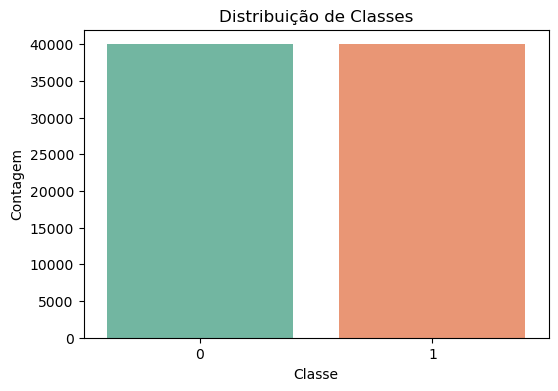

In [9]:
plt.figure(figsize=(6,4))
ax = sns.countplot(data=train_df, x="label", hue="label", palette="Set2")
ax.get_legend().remove()  # Remove a legenda se não for necessária
plt.title("Distribuição de Classes")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.show()


In [10]:
# Seleciona 4 imagens aleatórias de cada classe
sample_humano = metadata_df[metadata_df["label"]==0].sample(n=10000, random_state=42)
sample_ia = metadata_df[metadata_df["label"]==1].sample(n=10000, random_state=42)

#dando merge para pegar o nome do arquivo
sample_humano = pd.merge(sample_humano, train_df, on='id', how='left')
sample_ia = pd.merge(sample_ia, train_df, on='id', how='left')

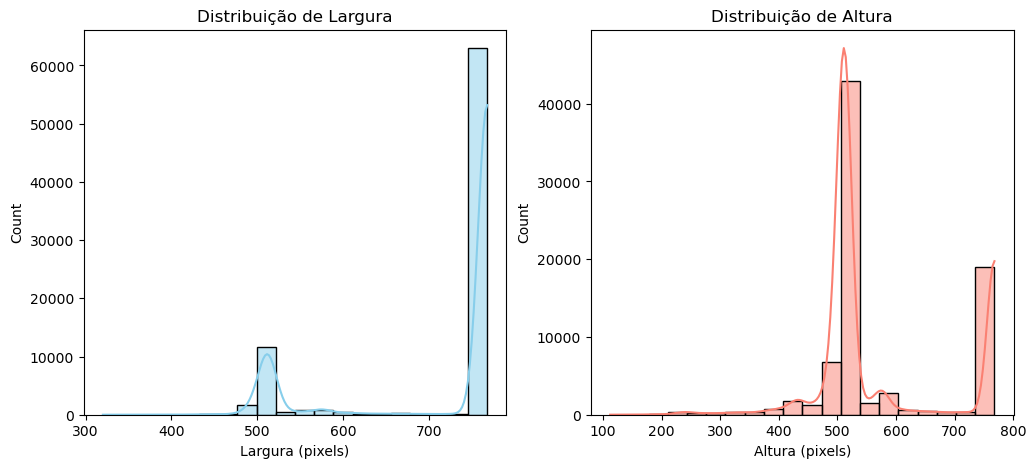

In [11]:
# Remover imagens com valores faltantes
res_df = metadata_df.dropna(subset=["width", "height"])

# Distribuição das resoluções (largura e altura)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(res_df["width"], kde=True, bins=20, color="skyblue")
plt.title("Distribuição de Largura")
plt.xlabel("Largura (pixels)")

plt.subplot(1,2,2)
sns.histplot(res_df["height"], kde=True, bins=20, color="salmon")
plt.title("Distribuição de Altura")
plt.xlabel("Altura (pixels)")
plt.show()


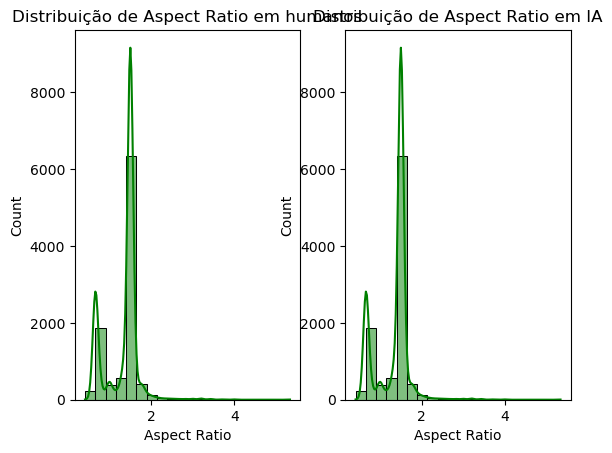

In [12]:
#comparando aspect_ratio de humano e IA
plt.subplot(1,2,1)
sns.histplot(sample_humano["aspect_ratio"], kde=True, bins=20, color="green")
plt.title("Distribuição de Aspect Ratio em humanos")
plt.xlabel("Aspect Ratio")


plt.subplot(1,2,2)
sns.histplot(sample_ia["aspect_ratio"], kde=True, bins=20, color="green")
plt.title("Distribuição de Aspect Ratio em IA")
plt.xlabel("Aspect Ratio")
plt.show()

# 📊 Análise da Distribuição de Dimensões das Imagens

## 🖼️ Distribuição de Largura
- A maioria das imagens tem larguras concentradas em dois picos principais:
  - **~500 pixels**
  - **~700 pixels** (predominante)

## 🖼️ Distribuição de Altura
- Grande pico em torno de **500 pixels**.
- Outro grupo significativo entre **700–800 pixels**.

## 🖼️ Distribuição de Aspect Ratio
- A maioria das imagens parece ter uma **proporção** entre 1 e 2

## 🔎 Insights
- **Dimensões padronizadas**: Possível redimensionamento ou captura padronizada.
- **Presença de outliers**: Pequena quantidade de imagens menores pode indicar anomalias.


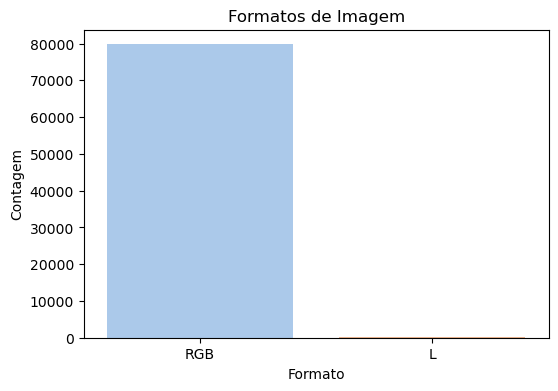

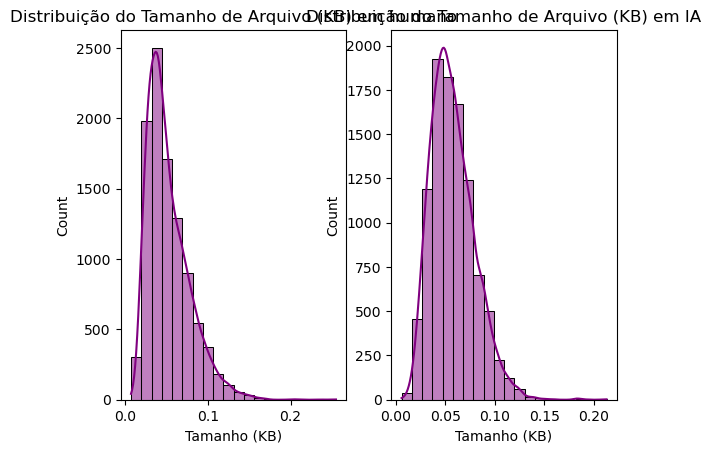

In [13]:
# Formato das imagens e tamanho dos arquivos
plt.figure(figsize=(6,4))
sns.countplot(data=metadata_df, x="mode", hue= 'mode', palette="pastel")
plt.title("Formatos de Imagem")
plt.xlabel("Formato")
plt.ylabel("Contagem")
plt.show()

# Tamanho dos arquivos
plt.subplot(1,2,1)
sns.histplot(sample_humano["file_size"].dropna()/1024, kde=True, bins=20, color="purple")
plt.title("Distribuição do Tamanho de Arquivo (KB) em humano")
plt.xlabel("Tamanho (KB)")

plt.subplot(1,2,2)
sns.histplot(sample_ia["file_size"].dropna()/1024, kde=True, bins=20, color="purple")
plt.title("Distribuição do Tamanho de Arquivo (KB) em IA")
plt.xlabel("Tamanho (KB)")
plt.show()


## 2. Inspeção Visual de Amostras

Exemplos aleatórios de imagens de cada classe


In [14]:
def load_image(file_path, target_size=None):
    try:
        im = Image.open(file_path).convert("RGB")
        if target_size:
            im = im.resize(target_size)
        return np.array(im)
    except Exception as e:
        return None


In [15]:
def plot_image_grid(samples, title):
    n_samples = min(5, len(samples))
    selected_samples = samples.sample(n=n_samples, replace=False,random_state=42)

    plt.figure(figsize=(15, 4))
    for i, (_, row) in enumerate(selected_samples.iterrows()):
        file_path = row["file_name"]
        img = load_image(file_path, target_size=(224, 224))
        if img is not None:
            plt.subplot(1, n_samples, i + 1)
            plt.imshow(img)
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

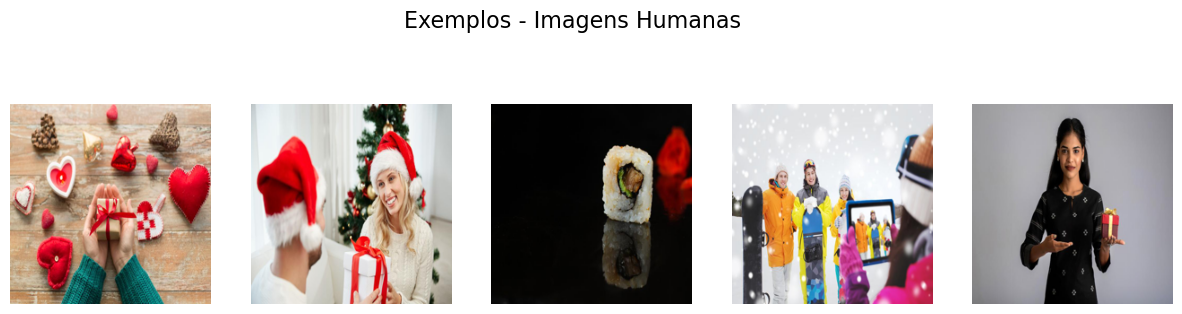

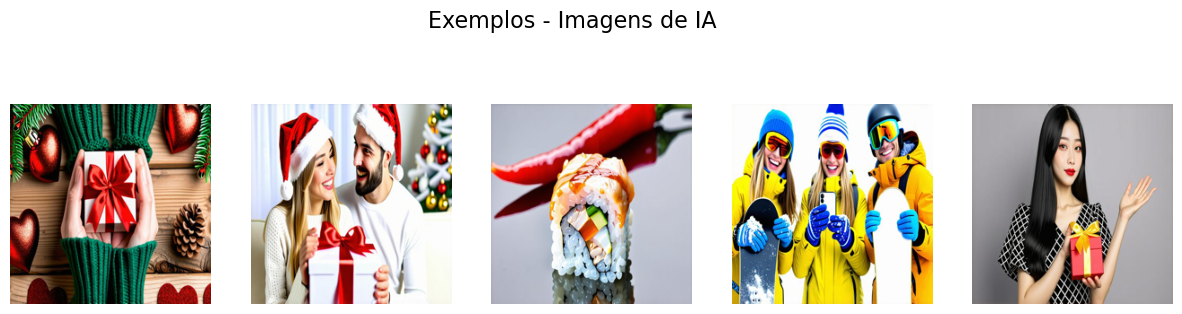

In [16]:
plot_image_grid(sample_humano, "Exemplos - Imagens Humanas")
plot_image_grid(sample_ia, "Exemplos - Imagens de IA")

## 4. Análise de Cores e Texturas

Nesta etapa calculamos e comparamos os histogramas de cores.


In [17]:
def analyze_color_distribution(df, n_samples):
    color_data = []
    for _, row in df.sample(n_samples).iterrows():
        img = imageio.imread(row['file_name'])
        if img.ndim == 3:  # Imagens coloridas
            for channel, color in zip(range(3), ['Blue','Red', 'Green', ]):
                color_data.append({
                    'class': row['label'],
                    'channel': color,
                    'intensity': img[:,:,channel].mean()
                })
    return pd.DataFrame(color_data)


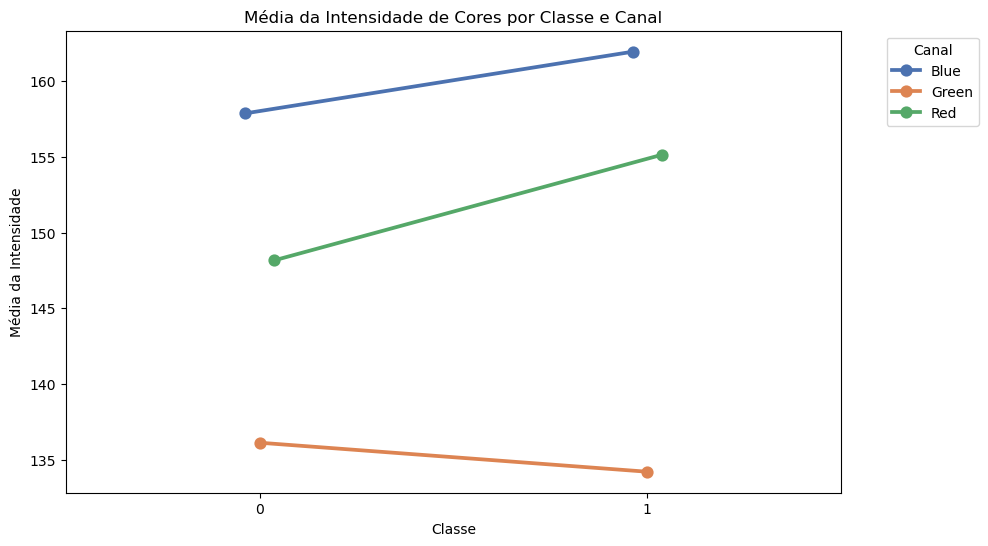

In [18]:
#reduzindo o número de amostras para acelerar a análise
color_df = analyze_color_distribution(train_df, 10000) # diminuir esse numero deixa mais rapido

# Agrega os dados: calcula a média e o desvio padrão da intensidade para cada classe e canal
agg_color = (
    color_df.groupby(['class', 'channel'])['intensity']
    .agg(['mean', 'std'])
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.pointplot(
    data=agg_color,
    x='class',
    y='mean',
    hue='channel',
    dodge=True,
    markers='o',
    capsize=0.1,
    palette='deep'
)
plt.title('Média da Intensidade de Cores por Classe e Canal')
plt.xlabel('Classe')
plt.ylabel('Média da Intensidade')
plt.legend(title='Canal', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 5. Estatísticas de Pixel

Calculando a média, variância, skewness, kurtosis e a nitidez (sharpness via variação do Laplaciano) para exemplificar as estatísticas de pixel de uma imagem.


In [19]:
sample_path_human = sample_humano.iloc[0]["file_name"]

# Verifica se o arquivo existe
if not os.path.exists(sample_path_human):
    raise FileNotFoundError(f"O arquivo {sample_path_human} não foi encontrado.")

img_sample_human = load_image(sample_path_human)
if img_sample_human is None:
    raise ValueError("A função load_image não conseguiu carregar a imagem. Verifique o arquivo ou o formato.")

# Converter para escala de cinza
img_gray_human = cv2.cvtColor(img_sample_human, cv2.COLOR_RGB2GRAY)

#Estatísticas de pixel para uma imagem (convertida para escala de cinza)
img_gray_float = np.array(img_gray_human, dtype=np.float32) / 255.0
mean_intensity = np.mean(img_gray_float)
variance_intensity = np.var(img_gray_float)
skewness_intensity = skew(img_gray_float.flatten())
kurtosis_intensity = kurtosis(img_gray_float.flatten())

laplacian = cv2.Laplacian(img_gray_human, cv2.CV_64F)
sharpness = laplacian.var()

print("RESULTADOS HUMANOS:")
print("Média de intensidade:", mean_intensity) #brilho médio da imagem
print("Variância de intensidade:", variance_intensity)
print("Skewness:", skewness_intensity)
print("Kurtosis:", kurtosis_intensity)
print("Sharpness (variação do Laplaciano):", sharpness)

RESULTADOS HUMANOS:
Média de intensidade: 0.8029728
Variância de intensidade: 0.07409752
Skewness: -1.2460501013666418
Kurtosis: 0.1775059637299896
Sharpness (variação do Laplaciano): 724.7250583692529


In [20]:
sample_path_ia = sample_ia.iloc[0]["file_name"]
# Verifica se o arquivo existe
if not os.path.exists(sample_path_ia):
    raise FileNotFoundError(f"O arquivo {sample_path_ia} não foi encontrado.")

img_sample_ia = load_image(sample_path_ia)
if img_sample_ia is None:
    raise ValueError("A função load_image não conseguiu carregar a imagem. Verifique o arquivo ou o formato.")

# Converter para escala de cinza
img_gray_ia = cv2.cvtColor(img_sample_ia, cv2.COLOR_RGB2GRAY)

#Estatísticas de pixel para uma imagem (convertida para escala de cinza)
img_gray_float = np.array(img_gray_ia, dtype=np.float32) / 255.0
mean_intensity = np.mean(img_gray_float)
variance_intensity = np.var(img_gray_float)
skewness_intensity = skew(img_gray_float.flatten())
kurtosis_intensity = kurtosis(img_gray_float.flatten())

# Sharpness: usar o Laplaciano
laplacian = cv2.Laplacian(img_gray_ia, cv2.CV_64F)
sharpness = laplacian.var()

print("RESULTADOS IA:")
print("Média de intensidade:", mean_intensity) #brilho médio da imagem
print("Variância de intensidade:", variance_intensity)
print("Skewness:", skewness_intensity)
print("Kurtosis:", kurtosis_intensity)
print("Sharpness (variação do Laplaciano):", sharpness)

RESULTADOS IA:
Média de intensidade: 0.7454445
Variância de intensidade: 0.090075366
Skewness: -0.8960109024952527
Kurtosis: -0.6460365318671504
Sharpness (variação do Laplaciano): 1380.0267664358928


### 1. **Sharpness (Variância do Laplaciano)**
- **Alta variância**: Bordas nítidas e imagem focada.
- **Baixa variância**: Imagem desfocada ou suavizada.

### 2. **Kurtosis**
- **Alta kurtosis**: Picos acentuados e valores extremos.
- **Baixa kurtosis**: Distribuição uniforme e caudas leves.

### 3. **Skewness**
- **Skewness positiva**: Mais pixels brilhantes.
- **Skewness negativa**: Mais pixels escuros.

### 4. **Variância de Intensidade**
- **Alta variância**: Alto contraste.
- **Baixa variância**: Baixo contraste.

---

## Resultados Comparativos

| Métrica                  | Humanos          | IA               |
|--------------------------|------------------|------------------|
| Média de intensidade     | **0.803**        | 0.745            |
| Variância de intensidade | 0.074            | **0.090**        |
| Skewness                 | **-1.246**       | -0.896           |
| Kurtosis                 | 0.178            | **-0.646**       |
| Sharpness (Laplaciano)   | 724.73           | **1380.03**      |

---
## Insights:
1. **Qualidade Técnica**: A imagem gerada por IA é **nitidamente superior** em foco e definição (sharpness 2x maior).
2. **Distribuição de Tons**:
   - Humanos: Alto contraste entre áreas escuras e poucas regiões brilhantes.
   - IA: Distribuição mais equilibrada, com menos extremos (kurtosis negativo).
3. **Brilho Médio**: A imagem humana parece mais clara, mas isso pode ser enganoso devido à presença de outliers brilhantes (skewness muito negativa).
4. **Contraste**: Apesar da IA ter maior variância, o contraste não é drasticamente diferente, sugerindo que ambas as imagens têm distribuições tonais relativamente controladas.

## 7. Detecção de Vieses

Investigando se há temas dominantes ou menos diversidade em uma classe.
Por exemplo, podemos verificar se as imagens geradas por IA apresentam resoluções ou tamanhos de arquivo mais uniformes do que as imagens humanas.


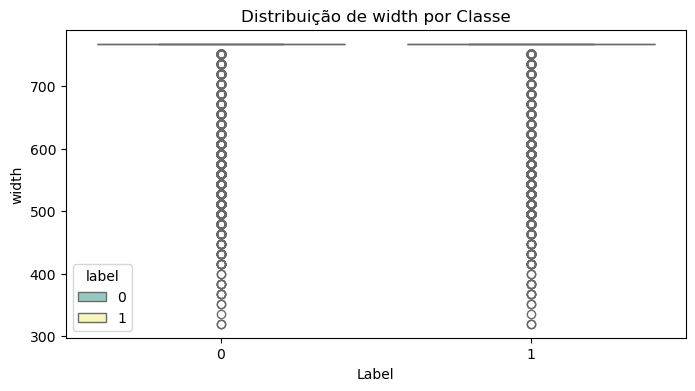

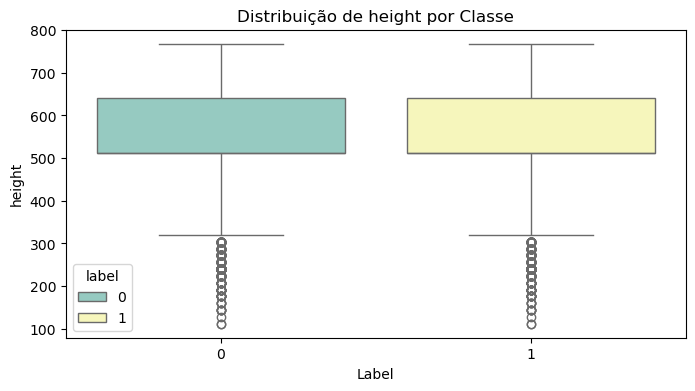

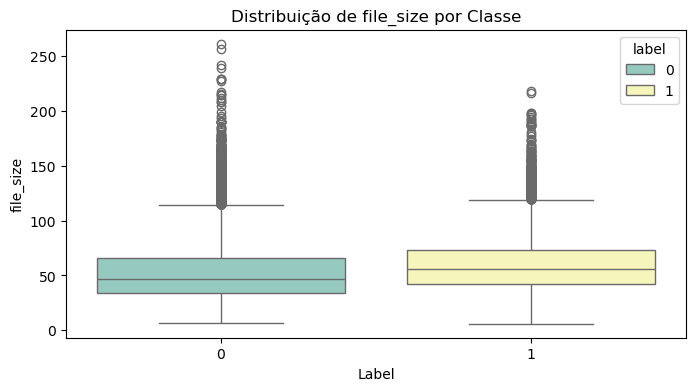

In [21]:
# Célula 15: Analisar a variabilidade de resolução e tamanho entre classes
for col in ["width", "height", "file_size"]:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=metadata_df, x="label",hue = 'label', y=col, palette="Set3")
    plt.title(f"Distribuição de {col} por Classe")
    plt.xlabel("Label")
    plt.ylabel(col)
    plt.show()
